In [4]:
from IPython.display import Image

# CNTK 103: Part B - Feed Forward Network with MNIST

We assume that you have successfully completed CNTK 103 Part A.

In this tutorial we will train a fully connected network on MNIST data. This notebook provides the recipe using Python APIs. If you are looking for this example in BrainScript, please look [here](https://github.com/Microsoft/CNTK/tree/v2.0.beta12.0/Examples/Image/GettingStarted)

## Introduction

**Problem** (recap from the CNTK 101):

The MNIST data comprises of hand-written digits with little background noise.

In [5]:
# Figure 1
Image(url= "http://3.bp.blogspot.com/_UpN7DfJA0j4/TJtUBWPk0SI/AAAAAAAAABY/oWPMtmqJn3k/s1600/mnist_originals.png", width=200, height=200)

**Goal**:
Our goal is to train a classifier that will identify the digits in the MNIST dataset. 

**Approach**:
The same 5 stages we have used in the previous tutorial are applicable: Data reading, Data preprocessing, Creating a model, Learning the model parameters and Evaluating (a.k.a. testing/prediction) the model. 
- Data reading: We will use the CNTK Text reader 
- Data preprocessing: Covered in part A (suggested extension section). 

Rest of the steps are kept identical to CNTK 102. 

In [6]:
# Import the relevant components
from __future__ import print_function
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

import cntk as C
from cntk import Trainer, learning_rate_schedule, UnitType
from cntk.io import CTFDeserializer, MinibatchSource, StreamDef, StreamDefs
from cntk.io import INFINITELY_REPEAT, FULL_DATA_SWEEP
from cntk.initializer import glorot_uniform
from cntk.layers import default_options, Input, Dense
from cntk.learner import sgd

# Select the right target device when this notebook is being tested:
if 'TEST_DEVICE' in os.environ:
    import cntk
    if os.environ['TEST_DEVICE'] == 'cpu':
        cntk.device.set_default_device(cntk.device.cpu())
    else:
        cntk.device.set_default_device(cntk.device.gpu(0))

%matplotlib inline

## Data reading

In this section, we will read the data generated in CNTK 103 Part B.

In [7]:
# Ensure we always get the same amount of randomness
np.random.seed(0)

# Define the data dimensions
input_dim = 784
num_output_classes = 10

## Data reading

In this tutorial we are using the MNIST data you have downloaded using CNTK_103A_MNIST_DataLoader notebook. The dataset has 60,000 training images and 10,000 test images with each image being 28 x 28 pixels. Thus the number of features is equal to 784 (= 28 x 28 pixels), 1 per pixel. The variable `num_output_classes` is set to 10 corresponding to the number of digits (0-9) in the dataset.

The data is in the following format:

    |labels 0 0 0 0 0 0 0 1 0 0 |features 0 0 0 0 ... 
                                                  (784 integers each representing a pixel)
    
In this tutorial we are going to use the image pixels corresponding the integer stream named "features". We define a `create_reader` function to read the training and test data using the [CTF deserializer](https://cntk.ai/pythondocs/cntk.io.html?highlight=ctfdeserializer#cntk.io.CTFDeserializer). The labels are [1-hot encoded](https://en.wikipedia.org/wiki/One-hot).  


In [8]:
# Read a CTF formatted text (as mentioned above) using the CTF deserializer from a file
def create_reader(path, is_training, input_dim, num_label_classes):
    return MinibatchSource(CTFDeserializer(path, StreamDefs(
        labels = StreamDef(field='labels', shape=num_label_classes, is_sparse=False),
        features   = StreamDef(field='features', shape=input_dim, is_sparse=False)
    )), randomize = is_training, epoch_size = INFINITELY_REPEAT if is_training else FULL_DATA_SWEEP)

In [9]:
# Ensure the training and test data is generated and available for this tutorial.
# We search in two locations in the toolkit for the cached MNIST data set.
data_found = False
for data_dir in [os.path.join("..", "Examples", "Image", "DataSets", "MNIST"),
                 os.path.join("data", "MNIST")]:
    train_file = os.path.join(data_dir, "Train-28x28_cntk_text.txt")
    test_file = os.path.join(data_dir, "Test-28x28_cntk_text.txt")
    if os.path.isfile(train_file) and os.path.isfile(test_file):
        data_found = True
        break
if not data_found:
    raise ValueError("Please generate the data by completing CNTK 103 Part A")
print("Data directory is {0}".format(data_dir))

Data directory is ..\Examples\Image\DataSets\MNIST


<a id='#Model Creation'></a>
## Model Creation

Our feed forward network will be relatively simple with 2 hidden layers (`num_hidden_layers`) with each layer having 200 hidden nodes (`hidden_layers_dim`). 

In [10]:
# Figure 2
Image(url= "http://cntk.ai/jup/feedforward_network.jpg", width=200, height=200)

If you are not familiar with the terms *hidden_layer* and *number of hidden layers*, please refer back to CNTK 102 tutorial.

For this tutorial: The number of green nodes (refer to picture above) in each hidden layer is set to 200 and the number of hidden layers (refer to the number of layers of green nodes) is 2. Fill in the following values:
- num_hidden_layers
- hidden_layers_dim

Note: In this illustration, we have not shown the bias node (introduced in the logistic regression tutorial). Each hidden layer would have a bias node.

In [11]:
num_hidden_layers = 2
hidden_layers_dim = 400

Network input and output: 
- **input** variable (a key CNTK concept): 
>An **input** variable is a container in which we fill different observations in this case image pixels during model learning (a.k.a.training) and model evaluation (a.k.a. testing). Thus, the shape of the `input_variable` must match the shape of the data that will be provided.  For example, when data are images each of  height 10 pixels  and width 5 pixels, the input feature dimension will be 50 (representing the total number of image pixels). More on data and their dimensions to appear in separate tutorials.


**Question** What is the input dimension of your chosen model? This is fundamental to our understanding of variables in a network or model representation in CNTK.


In [12]:
input = Input(input_dim)
label = Input(num_output_classes)

## Feed forward network setup

If you are not familiar with the feedforward network, please refer to CNTK 102. In this tutorial we are using the same network. 

In [13]:
def create_model(features):
    with default_options(init = glorot_uniform(), activation = C.ops.relu):
            h = features
            for _ in range(num_hidden_layers):
                h = Dense(hidden_layers_dim)(h)
            r = Dense(num_output_classes, activation = None)(h)
            return r
        
z = create_model(input)

`z` will be used to represent the output of a network.

We introduced sigmoid function in CNTK 102, in this tutorial you should try different activation functions. You may choose to do this right away and take a peek into the performance later in the tutorial or run the preset tutorial and then choose to perform the suggested activity.


** Suggested Activity **
- Record the training error you get with `sigmoid` as the activation function
- Now change to `relu` as the activation function and see if you can improve your training error

*Quiz*: Different supported activation functions can be [found here][]. Which activation function gives the least training error?

[found here]: https://github.com/Microsoft/CNTK/wiki/Activation-Functions

In [14]:
# Scale the input to 0-1 range by dividing each pixel by 256.
z = create_model(input/256.0)

### Learning model parameters

Same as the previous tutorial, we use the `softmax` function to map the accumulated evidences or activations to a probability distribution over the classes (Details of the [softmax function][] and other [activation][] functions).

[softmax function]: http://cntk.ai/pythondocs/cntk.ops.html#cntk.ops.softmax

[activation]: https://github.com/Microsoft/CNTK/wiki/Activation-Functions

## Training

Similar to CNTK 102, we use minimize the cross-entropy between the label and predicted probability by the network. If this terminology sounds strange to you, please refer to the CNTK 102 for a refresher. 

In [15]:
loss = C.ops.cross_entropy_with_softmax(z, label)

#### Evaluation

In order to evaluate the classification, one can compare the output of the network which for each observation emits a vector of evidences (can be converted into probabilities using `softmax` functions) with dimension equal to number of classes.

In [16]:
label_error = C.ops.classification_error(z, label)

### Configure training

The trainer strives to reduce the `loss` function by different optimization approaches, [Stochastic Gradient Descent][] (`sgd`) being one of the most popular one. Typically, one would start with random initialization of the model parameters. The `sgd` optimizer would calculate the `loss` or error between the predicted label against the corresponding ground-truth label and using [gradient-decent][] generate a new set model parameters in a single iteration. 

The aforementioned model parameter update using a single observation at a time is attractive since it does not require the entire data set (all observation) to be loaded in memory and also requires gradient computation over fewer datapoints, thus allowing for training on large data sets. However, the updates generated using a single observation sample at a time can vary wildly between iterations. An intermediate ground is to load a small set of observations and use an average of the `loss` or error from that set to update the model parameters. This subset is called a *minibatch*.

With minibatches we often sample observation from the larger training dataset. We repeat the process of model parameters update using different combination of training samples and over a period of time minimize the `loss` (and the error). When the incremental error rates are no longer changing significantly or after a preset number of maximum minibatches to train, we claim that our model is trained.

One of the key parameter for optimization is called the `learning_rate`. For now, we can think of it as a scaling factor that modulates how much we change the parameters in any iteration. We will be covering more details in later tutorial. 
With this information, we are ready to create our trainer. 

[optimization]: https://en.wikipedia.org/wiki/Category:Convex_optimization
[Stochastic Gradient Descent]: https://en.wikipedia.org/wiki/Stochastic_gradient_descent
[gradient-decent]: http://www.statisticsviews.com/details/feature/5722691/Getting-to-the-Bottom-of-Regression-with-Gradient-Descent.html

In [17]:
# Instantiate the trainer object to drive the model training
learning_rate = 0.2
lr_schedule = learning_rate_schedule(learning_rate, UnitType.minibatch)
learner = sgd(z.parameters, lr_schedule)
trainer = Trainer(z, (loss, label_error), [learner])

First let us create some helper functions that will be needed to visualize different functions associated with training.

In [18]:
from cntk.utils import get_train_eval_criterion, get_train_loss

# Define a utility function to compute the moving average sum.
# A more efficient implementation is possible with np.cumsum() function
def moving_average(a, w=5):
    if len(a) < w:
        return a[:]    # Need to send a copy of the array
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = get_train_loss(trainer)
        eval_error = get_train_eval_criterion(trainer)
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
        
    return mb, training_loss, eval_error

<a id='#Run the trainer'></a>
### Run the trainer

We are now ready to train our fully connected neural net. We want to decide what data we need to feed into the training engine.

In this example, each iteration of the optimizer will work on `minibatch_size` sized samples. We would like to train on all 60000 observations. Additionally we will make multiple passes through the data specified by the variable `num_sweeps_to_train_with`. With these parameters we can proceed with training our simple feed forward network.

In [19]:
# Initialize the parameters for the trainer
minibatch_size = 64
num_samples_per_sweep = 60000
num_sweeps_to_train_with = 10
num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size

In [20]:
# Create the reader to training data set
reader_train = create_reader(train_file, True, input_dim, num_output_classes)

# Map the data streams to the input and labels.
input_map = {
    label  : reader_train.streams.labels,
    input  : reader_train.streams.features
} 

# Run the trainer on and perform model training
training_progress_output_freq = 500

plotdata = {"batchsize":[], "loss":[], "error":[]}

for i in range(0, int(num_minibatches_to_train)):
    
    # Read a mini batch from the training data file
    data = reader_train.next_minibatch(minibatch_size, input_map = input_map)
    
    trainer.train_minibatch(data)
    batchsize, loss, error = print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
    
    if not (loss == "NA" or error =="NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)

Minibatch: 0, Loss: 2.3105, Error: 81.25%
Minibatch: 500, Loss: 0.2797, Error: 10.94%
Minibatch: 1000, Loss: 0.0954, Error: 1.56%
Minibatch: 1500, Loss: 0.1363, Error: 4.69%
Minibatch: 2000, Loss: 0.0084, Error: 0.00%
Minibatch: 2500, Loss: 0.0331, Error: 1.56%
Minibatch: 3000, Loss: 0.0177, Error: 0.00%
Minibatch: 3500, Loss: 0.0497, Error: 3.12%
Minibatch: 4000, Loss: 0.0154, Error: 0.00%
Minibatch: 4500, Loss: 0.0115, Error: 0.00%
Minibatch: 5000, Loss: 0.0079, Error: 0.00%
Minibatch: 5500, Loss: 0.0051, Error: 0.00%
Minibatch: 6000, Loss: 0.0045, Error: 0.00%
Minibatch: 6500, Loss: 0.0217, Error: 0.00%
Minibatch: 7000, Loss: 0.0254, Error: 1.56%
Minibatch: 7500, Loss: 0.0092, Error: 0.00%
Minibatch: 8000, Loss: 0.0020, Error: 0.00%
Minibatch: 8500, Loss: 0.0037, Error: 0.00%
Minibatch: 9000, Loss: 0.0004, Error: 0.00%


Let us plot the errors over the different training minibatches. Note that as we iterate the training loss decreases though we do see some intermediate bumps. 

Hence, we use smaller minibatches and using `sgd` enables us to have a great scalability while being performant for large data sets. There are advanced variants of the optimizer unique to CNTK that enable harnessing computational efficiency for real world data sets and will be introduced in advanced tutorials. 

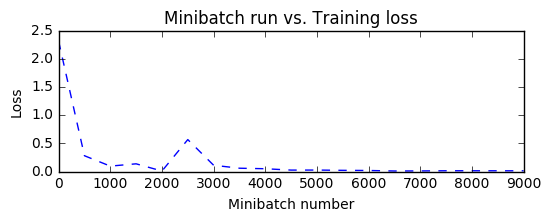

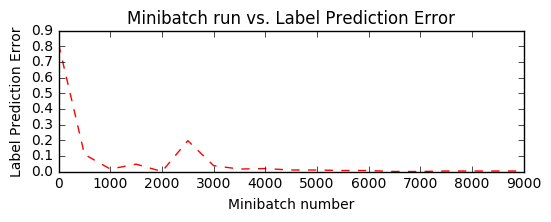

In [21]:
# Compute the moving average loss to smooth out the noise in SGD
plotdata["avgloss"] = moving_average(plotdata["loss"])
plotdata["avgerror"] = moving_average(plotdata["error"])

# Plot the training loss and the training error
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["avgloss"], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss')

plt.show()

plt.subplot(212)
plt.plot(plotdata["batchsize"], plotdata["avgerror"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error')
plt.show()

## Evaluation / Testing 

Now that we have trained the network, let us evaluate the trained network on the test data. This is done using `trainer.test_minibatch`.

In [22]:
# Read the training data
reader_test = create_reader(test_file, False, input_dim, num_output_classes)

test_input_map = {
    label  : reader_test.streams.labels,
    input  : reader_test.streams.features,
}

# Test data for trained model
test_minibatch_size = 512
num_samples = 10000
num_minibatches_to_test = num_samples // test_minibatch_size
test_result = 0.0

for i in range(num_minibatches_to_test):
    
    # We are loading test data in batches specified by test_minibatch_size
    # Each data point in the minibatch is a MNIST digit image of 784 dimensions 
    # with one pixel per dimension that we will encode / decode with the 
    # trained model.
    data = reader_test.next_minibatch(test_minibatch_size,
                                      input_map = test_input_map)

    eval_error = trainer.test_minibatch(data)
    test_result = test_result + eval_error

# Average of evaluation errors of all test minibatches
print("Average test error: {0:.2f}%".format(test_result*100 / num_minibatches_to_test))

Average test error: 1.70%


Note, this error is very comparable to our training error indicating that our model has good "out of sample" error a.k.a. generalization error. This implies that our model can very effectively deal with previously unseen observations (during the training process). This is key to avoid the phenomenon of overfitting.

We have so far been dealing with aggregate measures of error. Let us now get the probabilities associated with individual data points. For each observation, the `eval` function returns the probability distribution across all the classes. The classifier is trained to recognize digits, hence has 10 classes. First let us route the network output through a `softmax` function. This maps the aggregated activations across the network to probabilities across the 10 classes.

In [23]:
out = C.ops.softmax(z)

Let us a small minibatch sample from the test data.

In [24]:
# Read the data for evaluation
reader_eval = create_reader(test_file, False, input_dim, num_output_classes)

eval_minibatch_size = 25
eval_input_map = { input  : reader_eval.streams.features } 

data = reader_test.next_minibatch(eval_minibatch_size, input_map = test_input_map)

img_label = data[label].value
img_data = data[input].value
predicted_label_prob = [out.eval(img_data[i,:,:]) for i in range(img_data.shape[0])]

In [25]:
# Find the index with the maximum value for both predicted as well as the ground truth
pred = [np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
gtlabel = [np.argmax(img_label[i,:,:]) for i in range(img_label.shape[0])]

In [26]:
print("Label    :", gtlabel[:25])
print("Predicted:", pred)

Label    : [4, 5, 6, 7, 8, 9, 7, 4, 6, 1, 4, 0, 9, 9, 3, 7, 8, 4, 7, 5, 8, 5, 3, 2, 2]
Predicted: [4, 6, 6, 7, 8, 9, 7, 4, 6, 1, 4, 0, 9, 9, 3, 7, 8, 0, 7, 5, 8, 5, 3, 2, 2]


Let us visualize some of the results

Image Label:  9


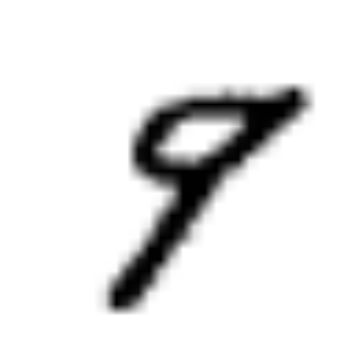

In [27]:
# Plot a random image
sample_number = 5
plt.imshow(img_data[sample_number].reshape(28,28), cmap="gray_r")
plt.axis('off')

img_gt, img_pred = gtlabel[sample_number], pred[sample_number]
print("Image Label: ", img_pred)

**Exploration Suggestion**
-  Try exploring how the classifier behaves with different parameters - suggest changing the `minibatch_size` parameter from 25 to say 64 or 128. What happens to the error rate? How does the error compare to the logistic regression classifier?
- Suggest trying to increase the number of sweeps
- Can you change the network to reduce the training error rate? When do you see *overfitting* happening?

#### Code link

If you want to try running the tutorial from Python command prompt please run the [SimpleMNIST.py](https://github.com/Microsoft/CNTK/tree/v2.0.beta12.0/Examples/Image/Classification/MLP/Python) example.